# Wind Power Predictions

## Unzip Meteodyn.zip to Data

(Remember to upload zip-file)

In [1]:
from tqdm import tqdm # for progress bar as alternative or suplement, use EXAMPLE: for f in tqdm(os.listdir(label)):
import time # for the script below
# get the matlab known and loved funtion
def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "  --Elapsed time: %.2f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

In [2]:
# Choose unpacking method
if 0:
  !unzip Meteodyn.zip -d Data
if 1:
  # Keep eye on data as it trains to prevent overfitting
  # special insertion for colab, also paths
  #upload using colab, method adjusted from a search
  from google.colab import drive
  drive.mount('/content/drive')
  path = "/content/drive/MyDrive/Colab Notebooks/22 - Project"
# path = " Your path Emil "
# To save: Use torch.save(tensor, 'file.pt') and torch.load('file.pt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Visualisation

In [3]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

if 1:
  # Dataframes:
  case = str(1)
  df1 = pd.read_csv(path+"/Data/Raw/Proj_NWP_Case"+case+".csv")
  df2 = pd.read_csv(path+"/Data/Raw/Proj_Measurements_Case"+case+".csv")
else:
  # Dataframes:
  df1 = pd.read_csv("Data/Datasets/Case1/Proj_NWP_Case1.csv")
  df2 = pd.read_csv("Data/Datasets/Case1/Proj_Measurements_Case1.csv")

# Attributes:
dir_id   = np.arange(len(df1.columns))[df1.columns.str.contains("Direction")]
speed_id = np.arange(len(df1.columns))[df1.columns.str.contains("Speed")]
temp_id  = np.arange(len(df1.columns))[df1.columns.str.contains("Temperature")]
dens_id  = np.arange(len(df1.columns))[df1.columns.str.contains("Density")]
other_id = np.asarray(list(set([x for x in range(len(df1.columns))]).difference(set(np.r_[dir_id, speed_id, temp_id, dens_id])))) # Dirty Hack

# Target:
targets = df2['Park Power [KW]']

# Non-Nan Ids
non_nan_ids = (1 - df2['Park Power [KW]'].isnull().values) * np.arange(df2.shape[0])

if 0: # Make plots
  # Air Directions:
  fig = plt.figure(figsize=(8,5))
  for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    col_name = df1.columns[dir_id[i]]
    ax.hist(df1[col_name], bins=360, density=True)
    ax.title.set_text(col_name)
    ax.set_xlabel("Air Direction [deg]")

  fig.suptitle("Air Directions at [10, 50, 100, 150] \n meters above wind turbine\n")

  fig.tight_layout(rect=[0, 0.03, 1, 0.9])
  plt.show()

  # Air Speeds:
  fig = plt.figure(figsize=(8,5))
  for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    col_name = df1.columns[speed_id[i]]
    ax.hist(df1[col_name], bins=[x for x in range(int(np.ceil(np.max(np.max(df1[df1.columns[speed_id]])))))], density=True)
    ax.title.set_text(col_name)
    ax.set_xlabel("Air Speed [m/s]")

  fig.suptitle("Air Speeds at [10, 50, 100, 150] \n meters above wind turbine\n")

  fig.tight_layout(rect=[0, 0.03, 1, 0.9])
  plt.show()

  # Air Temperatures:
  fig = plt.figure(figsize=(8,5))
  for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    col_name = df1.columns[temp_id[i]]
    ax.hist(df1[col_name], bins=360, density=True)
    ax.title.set_text(col_name)
    ax.set_xlabel("Temperatures [C]")

  fig.suptitle("Air Temperatures at [10, 50, 100, 150] \n meters above wind turbine\n")

  fig.tight_layout(rect=[0, 0.03, 1, 0.9])
  plt.show()

  # Air Densities:
  fig = plt.figure(figsize=(8,5))
  for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    col_name = df1.columns[dens_id[i]]
    ax.hist(df1[col_name], bins=360, density=True)
    ax.title.set_text(col_name)
    ax.set_xlabel("Air Densities")

  fig.suptitle("Air Densities at [10, 50, 100, 150] \n meters above wind turbine\n")

  fig.tight_layout(rect=[0, 0.03, 1, 0.9])
  plt.show()

  #df2 = pd.read_csv("Data/Datasets/Case1/Proj_Measurements_Case1.csv") # is loaded above
  value_ids = (1 - df2['Park Power [KW]'].isnull().values) * np.arange(df2.shape[0])
  plt.hist(df2['Park Power [KW]']/(33*1500), bins=200)
  plt.show()

## Preprocessing Data

### Data Normalization and picking - first method

In [4]:
if 0: 
  # Imports
  DAYTIME = False
  # Create new dataframe and sort
  df3 = df1.copy()
  df3 = df3.reindex(columns = list(df1.columns[np.r_[other_id, dir_id, speed_id, temp_id, dens_id]].values))

  if DAYTIME:
    import datetime

    # Split Date_Time into year, month, week, week-day, month-day, hourly quarter
    date_time_array = np.zeros((len(df3['Date_Time']), 6))

    for i in range(len(df3['Date_Time'])):
      YYYY, mm, w, dd, HH, MM, SS = (datetime.datetime.strptime(df3['Date_Time'][i], "%Y-%m-%d %H:%M:%S").strftime("%Y, %m, %w, %d, %H, %M, %S")).split(",")
      date_time_array[i, :] = np.array([float(YYYY), float(mm), np.floor(float(mm)/7 + 1), float(w), float(dd), float(HH)*4 + float(MM)/15])

    # Add datetime data to attributes:
    index_list = ["Year", "Month", "Week", "Weekday", "Monthday", "Hourly_Quarter"]
    for i in range(len(index_list)):
      df3[index_list[i]] = pd.Series(date_time_array[:, i], index=df3.index)

    # Remove datetime features...:
    df3 = df3.iloc[:, 0:17]

  # Remove Date_Time attribute:
  df3 = df3.iloc[:, 1:]


  # Normalize attributes:
  if 0: # first approch
    df3_norm = df3.copy()
    df3_norm.iloc[:,0] /= 1013.25   # Average sea pressure [mbar]
    df3_norm.iloc[:,1:5] /= 360     # Conversion [deg -> [0,1]-interval]
    df3_norm.iloc[:, 5:9] /= 12     # Divide by lowest speed that achieves 100% power output
    df3_norm.iloc[:,13:17] /= 1.225 # Average air density [kg/m^3]
    #df3_norm.iloc[:, -1] -= 2016    # Subtract starting year [yr] # not to be done if removing day time
    df3_norm.iloc[:, 9:13] = (df3_norm.iloc[:, 9:13] - np.mean(df3_norm.iloc[:, 9:13])) /  np.std(df3_norm.iloc[:, 9:13]) # Standardized Normalization of Temperature
    df3_norm.iloc[:,0:17] -= 0.5 # normalize around 0.5 instead of 1



  # Add Park Power Output to dataframe: # kept the same way
  PP = df2['Park Power [KW]'] # / (33*1500) # by capacity
  df3['PP'] = pd.Series(PP, index=df3.index)

  #normalize values in every column # second
  df3_norm = (df3-df3.min())/ (df3.max() - df3.min())
  #df3_norm = df3_norm.iloc[35713:] # cut of the first values to mabye allign



  # Remove rows with no target values:
  df_final_unaltered = df3_norm[~df3_norm.iloc[:, -1].isnull()]
  new_index = ['Pressure_seaLevel',	'Direction_10m'	,'Direction_50m',	'Direction_100m',	'Direction_150m',	'Speed_10m',	'Speed_50m'	,'Speed_100m',	'Speed_150m',	'Temperature_10m'	,'Temperature_50m',	'Temperature_100m'	,'Temperature_150m'	,'Air Density_10m',	'Air Density_50m'	,'Air Density_100m',	'Air Density_150m'	,'PP']
  df_final_unaltered = df_final_unaltered.reindex(columns=new_index)

In [5]:
if 0:
  # Reset
  df = df_final_unaltered
  #df.Speed_50m
  # Only takes POSITIVE AND!!! non-ZERO power
  df = df.query("PP >= 0.0") # consider setting > 0.0001
  print(sum(df.iloc[:,-1]<=0))
  #print(df.shape)
  # CUT OF QUESTIONABLE DATA, ~ is negation
  #df_final = df3_norm[~df3_norm.iloc[:, -1].isnull()]
  #df = df.query('Speed_150m >= 0.5 & PP <= 0.4') # does the inverse, makes PP.max() = 0.4
  #df = df[~(( df.Speed_150m >= 0.2 ) & ( df.PP <= 0.2 ))]
  df = df.query('not((Speed_100m > 0.20) & (PP < 0.20))') # cut out wind blowing, but no power = Maintenaince?
  df = df.query('not((Speed_100m < 0.20) & (PP > 0.80))') # cut out power from no wind = error in forecast/mismatch?
  #df = df.query('(Speed_100m < 0.25) & (PP > 0.8)')
  ## good enought?
  df_final = df
  df_final.reindex(columns=new_index)
  print("Sample value of features:\n",df_final.iloc[0])
  print("Mean values of target: ",(df_final.iloc[:,-1]).mean())
  print("Shape is: ",df_final.shape)

#### Processed vizualized

In [6]:
if 0:
  # Attributes NORMALIZED:
  dir_id   = np.arange(len(df_final.columns))[df_final.columns.str.contains("Direction")]
  speed_id = np.arange(len(df_final.columns))[df_final.columns.str.contains("Speed")]
  temp_id  = np.arange(len(df_final.columns))[df_final.columns.str.contains("Temperature")]
  dens_id  = np.arange(len(df_final.columns))[df_final.columns.str.contains("Density")]
  other_id = np.asarray(list(set([x for x in range(len(df_final.columns))]).difference(set(np.r_[dir_id, speed_id, temp_id, dens_id])))) # Dirty Hack

  # Target:
  targets = df_final['PP']

  # Non-Nan Ids
  non_nan_ids = (1 - df_final['PP'].isnull().values) * np.arange(df_final.shape[0])

  # Air Directions:
  fig = plt.figure(figsize=(8,5))
  for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    col_name = df_final.columns[dir_id[i]]
    ax.hist(df_final[col_name], bins=360, density=True)
    ax.title.set_text(col_name)
    ax.set_xlabel("Air Direction [deg]")

  fig.suptitle("Air Directions at [10, 50, 100, 150] \n meters above wind turbine\n")

  fig.tight_layout(rect=[0, 0.03, 1, 0.9])
  plt.show()

  # Air Speeds:
  fig = plt.figure(figsize=(8,5))
  for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    col_name = df_final.columns[speed_id[i]]
    ax.hist(df_final[col_name], bins=100, density=True)
    ax.title.set_text(col_name)
    ax.set_xlabel("Air Speed [m/s]")

  fig.suptitle("Air Speeds at [10, 50, 100, 150] \n meters above wind turbine\n")

  fig.tight_layout(rect=[0, 0.03, 1, 0.9])
  plt.show()

  # Air Temperatures:
  fig = plt.figure(figsize=(8,5))
  for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    col_name = df_final.columns[temp_id[i]]
    ax.hist(df_final[col_name], bins=360, density=True)
    ax.title.set_text(col_name)
    ax.set_xlabel("Temperatures [C]")

  fig.suptitle("Air Temperatures at [10, 50, 100, 150] \n meters above wind turbine\n")

  fig.tight_layout(rect=[0, 0.03, 1, 0.9])
  plt.show()

  # Air Densities:
  fig = plt.figure(figsize=(8,5))
  for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    col_name = df_final.columns[dens_id[i]]
    ax.hist(df_final[col_name], bins=360, density=True)
    ax.title.set_text(col_name)
    ax.set_xlabel("Air Densities")

  fig.suptitle("Air Densities at [10, 50, 100, 150] \n meters above wind turbine\n")

  fig.tight_layout(rect=[0, 0.03, 1, 0.9])
  plt.show()

  #df2 = pd.read_csv("Data/Datasets/Case1/Proj_Measurements_Case1.csv") # is loaded above
  #value_ids = (1 - df2['PP'].isnull().values) * np.arange(df2.shape[0])
  plt.hist(df_final['PP'], bins=200)
  plt.show()

In [7]:
#SCATTER
if 0:
  for i, key in enumerate(df_final.keys()):
      fig = plt.figure()
      col_name = df_final.keys()[i]
      plt.scatter(df_final[key], df_final.iloc[:, -1], alpha=0.005)
      plt.title(col_name+" vs. Park Power")
      plt.show()

### Alternate sorting - is based on power-curve
change: muliplier = [1 , 3 , 7 , 10]


In [8]:
# Preprocess data: (Removing erroneous rows and normalize/standardize data)
if 1:
    import datetime
    muliplier = 1 # 1=10% max deviation from power curver
    # Renaming
    y = targets
    X = df1.copy().iloc[:len(y), 1:]

    # Remember what rows contain bad data:
    rows_to_remove = np.zeros((len(y)), dtype=int)

    # 1. Remove rows with negative power output:
    rows_to_remove += (y < 0) * 1

    # 2. Remove rows with NaN power output:
    rows_to_remove += y.isnull() * 1

    # 3. Remove rows with high power output but wrong wind direction

    #   3.1: Find optimal wind direction:
    opt_dirs = []
    for dir in dir_id:
        (size, _) = np.histogram(X[X.columns[dir - 1]], bins=359)
        opt_dirs.append(size.argmax())
    opt_dir = np.array([opt_dirs]).mean()

    #   3.2: Cross reference power with wind directions:
    good_angle = 45
    good_dirs = ((X[X.columns[dir_id - 1]] > (opt_dir - good_angle)) & (X[X.columns[dir_id - 1]] < (opt_dir + good_angle))).prod(
        axis=1).astype(bool)
    bad_dirs = (1 - good_dirs).astype(bool)

    rows_to_remove += y * bad_dirs > (49500 * 0.1)

    # 4. Remove rows with high power output but low wind speed:
    rows_to_remove += ((((X[X.columns[speed_id - 1]] < 3).prod(axis=1)).astype(bool) * y) > 33 * 12)

    # 5. Remove rows with no power output but high wind speeds and good directions
    if 0:
        rows_to_remove += (((X[X.columns[speed_id - 1]] > 4).prod(axis=1) * good_dirs) * (y < 37 / 2 * 33))
        rows_to_remove += (((X[X.columns[speed_id - 1]] > 5).prod(axis=1) * good_dirs) * (y < 122 / 2 * 33))
        rows_to_remove += (((X[X.columns[speed_id - 1]] > 6).prod(axis=1) * good_dirs) * (y < 233 / 2 * 33))
        rows_to_remove += (((X[X.columns[speed_id - 1]] > 7).prod(axis=1) * good_dirs) * (y < 389 / 2 * 33))
        rows_to_remove += (((X[X.columns[speed_id - 1]] > 8).prod(axis=1) * good_dirs) * (y < 597 / 2 * 33))
        rows_to_remove += (((X[X.columns[speed_id - 1]] > 9).prod(axis=1) * good_dirs) * (y < 862 / 2 * 33))
        rows_to_remove += (((X[X.columns[speed_id - 1]] > 10).prod(axis=1) * good_dirs) * (y < 1166 / 2 * 33))
        rows_to_remove += (((X[X.columns[speed_id - 1]] > 11).prod(axis=1) * good_dirs) * (y < 1500 / 2 * 33))

    # 6. Remove rows with power output deviating by more than 10% from the theoretical value:
    speeds = np.arange(24)
    powers = np.array([0, 0, 0, 12.3, 36.9, 122.2, 233.0, 389.1, 597.1, 861.8, 1166.0, 1495.4, 1500.2, 1500.2, 1500.2,
                       1500.2, 1500.2, 1500.2, 1500.2, 1500.2, 1500.2, 1500.2, 1500.2, 1500.2])
    rows_to_remove += (np.abs(y - np.polyval(np.polyfit(speeds, powers * 33, deg=16), X['Speed_100m'])) > 4950*muliplier)

    # 7. Check if the power output does not change:
    list1 = [y[i:(-10 + i)] for i in range(10)]
    rows_to_remove += np.r_[(np.array(list1).std(axis=0) == 0), np.zeros(10, dtype=bool)]

    # Convert:
    rows_to_keep = rows_to_remove == 0

    # Allocate dataframe:
    df3 = df1.copy().iloc[:len(y)]

    # One-hot encode each month
    one_hot_array = np.zeros((len(df3['Date_Time']), 12))
    for i in range(len(df3['Date_Time'])):
        YYYY, mm, w, dd, HH, MM, SS = (datetime.datetime.strptime(df3['Date_Time'][i], "%Y-%m-%d %H:%M:%S").strftime(
            "%Y, %m, %w, %d, %H, %M, %S")).split(",")
        one_hot_array[i, [int(mm) - 1]] = 1

    # Group attributes
    df3 = df3.reindex(columns=list(df1.columns[np.r_[other_id, dir_id, speed_id, temp_id, dens_id]].values))

    # Remove timestamps
    df3_norm = df3.iloc[:, 1:]

    # Append ids:
    df3_norm["ID"] = pd.Series(df3_norm.index.values, index=df3_norm.index)

    # Append months:
    index_list = [f"Month {x + 1}" for x in range(12)]
    for i in range(len(index_list)):
        df3_norm[index_list[i]] = pd.Series(one_hot_array[:, i], index=df3_norm.index)

    # Remove all bad rows:
    df3_norm = df3_norm[rows_to_keep]

    # Normalizations:
    df3_norm.iloc[:, 0] = (df3_norm.iloc[:, 0] - df3_norm.iloc[:, 0].mean()) / df3_norm.iloc[:, 0].std()

    df3_norm.iloc[:, 1:5] = df3_norm.iloc[:, 1:5] / 180 * np.pi - np.pi

    mu = df3_norm.iloc[:, 5:17].mean(axis=0)
    std = df3_norm.iloc[:, 5:17].std(axis=0)

    df3_norm.iloc[:, 5:17] = (df3_norm.iloc[:, 5:17] - mu) / std

    # Normalize ID's to be between 0 and 1:
    df3_norm['ID'] = df3_norm['ID'] / df3_norm['ID'].max()

    # Remove bad rows:
    y = y[rows_to_keep]

    # Set a ceiling for power production:
    y[y > 49500] = 49500

    # Append power production to dataframe:
    df3_norm['Park Power [KW]'] = pd.Series(y, index=df3_norm.index)
    df3_norm.iloc[:, -1] = df3_norm.iloc[:, -1] / df3_norm.iloc[:, -1].max()

    df_final = df3_norm


In [9]:
df_final

,Pressure_seaLevel,Direction_10m,Direction_50m,Direction_100m,Direction_150m,Speed_10m,Speed_50m,Speed_100m,Speed_150m,Temperature_10m,Temperature_50m,Temperature_100m,Temperature_150m,Air Density_10m,Air Density_50m,Air Density_100m,Air Density_150m,ID,Month 1,Month 2,Month 3,Month 4,Month 5,Month 6,Month 7,Month 8,Month 9,Month 10,Month 11,Month 12,Park Power [KW]
145,1.003116,1.326450,1.308997,1.326450,1.343904,1.656519,1.439223,1.884085,1.911124,-1.629692,-1.629692,-1.629692,-1.629692,1.658333,1.658333,1.658333,1.658333,0.000985,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.804283
172,0.717099,1.343904,1.326450,1.343904,1.361357,1.354300,1.181990,1.505004,1.537113,-1.343473,-1.343473,-1.343473,-1.343473,1.309500,1.309500,1.309500,1.309500,0.001169,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.699394
173,0.714675,1.343904,1.326450,1.343904,1.361357,1.360467,1.174845,1.531019,1.568082,-1.350678,-1.350678,-1.350678,-1.350678,1.322420,1.322420,1.322420,1.322420,0.001175,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.801798
182,0.697708,1.326450,1.308997,1.343904,1.361357,1.428313,1.160554,1.724276,1.756279,-1.414864,-1.414864,-1.414864,-1.414864,1.387019,1.387019,1.387019,1.387019,0.001236,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.772727
233,0.455320,1.186824,1.134464,1.256637,1.291544,0.793034,0.446019,1.300598,1.482322,-1.581225,-1.581225,-1.581225,-1.581225,1.516216,1.516216,1.516216,1.516216,0.001583,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.598606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147188,0.633475,1.361357,1.099557,1.710423,1.815142,-0.348000,-0.511458,0.189370,0.457960,-0.678029,-0.678029,-0.678029,-0.678029,0.650594,0.650594,0.650594,0.650594,0.999973,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061616
147189,0.632263,1.361357,1.099557,1.710423,1.797689,-0.360336,-0.532894,0.193086,0.467489,-0.682614,-0.682614,-0.682614,-0.682614,0.650594,0.650594,0.650594,0.650594,0.999980,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063232
147190,0.631051,1.361357,1.117011,1.710423,1.797689,-0.372671,-0.554330,0.196803,0.474636,-0.686544,-0.686544,-0.686544,-0.686544,0.650594,0.650594,0.650594,0.650594,0.999986,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068384
147191,0.629839,1.361357,1.117011,1.692969,1.780236,-0.378839,-0.561476,0.200519,0.486547,-0.689819,-0.689819,-0.689819,-0.689819,0.663513,0.663513,0.663513,0.663513,0.999993,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.060687


In [10]:
# Preprocess data: (Remove rows corresponding to nan-targets)
if 0:
    # Create new dataframe and sort
    df3 = df1.copy()
    df3.iloc[0:df1.shape[0] - 35713] = df1.iloc[35713:].values
    df3 = df3.iloc[0:df3.shape[0] - 35713]
    # df3 = df3.reindex(columns=list(df1.columns[np.r_[other_id, dir_id, speed_id, temp_id, dens_id]].values))

    # One hot encoding: (Month [12], Hour [24])
    one_hot_array = np.zeros((len(df3['Date_Time']), (12 + 24)))
    # One hot encoding: (Month [12], Quarters [96])
    # one_hot_array = np.zeros((len(df3['Date_Time']), (12+96)))

    for i in range(len(df3['Date_Time'])):
        YYYY, mm, w, dd, HH, MM, SS = (datetime.datetime.strptime(df3['Date_Time'][i], "%Y-%m-%d %H:%M:%S").strftime(
            "%Y, %m, %w, %d, %H, %M, %S")).split(",")
        date_time_array[i, :] = np.array(
            [float(YYYY), float(mm), np.floor(float(mm) // 7 + 1), float(w), float(dd), float(HH) * 4 + float(MM) / 15])
        one_hot_array[i, [int(mm) - 1, 12 + int(HH)]] = 1
        # one_hot_array[i, [int(mm)-1, 12+int(int(HH)*4 + int(MM)/15)]] = 1

    if 0:
        # Add datetime data to attributes:
        index_list = ["Year", "Month", "Week", "Weekday", "Monthday", "Hourly_Quarter"]
        for i in range(len(index_list)):
            df3[index_list[i]] = pd.Series(date_time_array[:, i], index=df3.index)
    else:
        index_list = [f"Month {x + 1}" for x in range(12)] + [f"Hour {x + 1}" for x in range(24)]
        # index_list = [f"Month {x + 1}" for x in range(12)] + [f"Quarter {x + 1}" for x in range(96)]
        for i in range(len(index_list)):
            df3[index_list[i]] = pd.Series(one_hot_array[:, i], index=df3.index)
    df3["ID"] = pd.Series(df3.index.values, index=df3.index)
    df3 = df3.copy()


    # Normalization:
    def mapRange(value, inMin, inMax, outMin, outMax):
        return outMin + (((value - inMin) / (inMax - inMin)) * (outMax - outMin))


    # Normalize attributes one by one:
    if 0:
        df3_norm = df3.copy()
        df3_norm.iloc[:, 0] /= 1013.25  # Average sea pressure [mbar]
        df3_norm.iloc[:, 1:5] /= 360  # Conversion [deg -> [0,1]-interval]
        df3_norm.iloc[:, 5:9] /= 12  # Divide by lowest speed that achieves 100% power output
        df3_norm.iloc[:, 13:17] /= 1.225  # Average air density [kg/m^3]
        df3_norm.iloc[:, 17] -= 2016  # Subtract starting year [yr]
        df3_norm.iloc[:, 9:13] = (df3_norm.iloc[:, 9:13] - np.mean(df3_norm.iloc[:, 9:13])) / np.std(
            df3_norm.iloc[:, 9:13])  # Standardized Normalization of Temperature
    else:
        df3_norm = df3.iloc[:, 1:].copy()
        df3_norm /= np.max(df3, axis=0)

    # Add Park Power Output to dataframe:
    PP = df2['Park Power [KW]']
    df3_norm['Park Power [KW]'] = pd.Series(PP.iloc[0:df1.shape[0]] / np.max(PP), index=df3.index)

    # Remove rows with no target values:
    df_final = df3_norm[~df3_norm.iloc[:, -1].isnull()]


### Data functions

In [11]:
def split_data(data_frame):
  " Takes dataframe and splits into train-, validation- and test set"
  
  df = data_frame

  # Observations:
  num_obs = df.shape[0]

  # Train-, validation-, and testing set:
  train_valid_split, valid_test_split = np.round(num_obs * np.array([0.7, 0.9]), -2).astype(int)

  train_data = df.iloc[:train_valid_split, :]
  valid_data = df.iloc[train_valid_split:valid_test_split, :]
  test_data  = df.iloc[valid_test_split:, :]

  return train_data, valid_data, test_data


def attributes_n_targets(data_set, num_prev_obs = 1):

  # Pre-allocate attributes and targets:
  x = np.zeros((data_set.shape[0] - (num_prev_obs-1), data_set.shape[1]*num_prev_obs - 1))
  y = np.zeros((x.shape[0], 1))

  # Fill in attributes and targets:
  for i in range(data_set.shape[0] - num_prev_obs):
    arr = data_set.iloc[i:i+num_prev_obs, :].to_numpy().reshape(-1)
    x[i, :] = arr[:-1]
    y[i, :] = arr[-1]
  
  return x, y


def num_inputs(data_set, num_prev_obs = 1):
  return data_set.shape[1] * num_prev_obs - 1

train_data, valid_data, test_data = split_data(df_final)

## PCA - requires first sorting method

### 2x PCA components, 

In [12]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [13]:
if 0:
  # Similar setup to make following easy
  x = df3.copy()
  # Add Park Power Output to dataframe: # kept the same way
  PP = df2['Park Power [KW]'] / (33*1500)
  x['Park Power'] = pd.Series(PP, index=x.index)

  # Remove rows with no target values:
  df = x[~x.iloc[:, -1].isnull()] # is all together
  df = x
  y = df.iloc[:,-1]
  x = df.iloc[:,0:17]
  print(df.iloc[0:10,0:18])

  # make x to mu=0, sigma=1
  x = StandardScaler().fit_transform(x)
  pd.DataFrame(data = x, ).head()

  pca = PCA(n_components=2)

  principalComponents = pca.fit_transform(x)

  principalDf = pd.DataFrame(data = principalComponents
              , columns = ['principal component 1', 'principal component 2'])

  #principalDf.head(5)
  finalDf = pd.concat([principalDf, df['Park Power']], axis = 1)
  finalDf = finalDf[~y.iloc[:].isnull()]
  finalDf.head(12)

  print(pca.explained_variance_ratio_)

  targetsLow = [0, 0.1 , 0.5 , 0.8]
  targetsHigh = [0.1, 0.5 , 0.8 , 1]
  colors = ['r', 'g', 'b' , 'y']
  for targetL,targetH, color in zip(targetsLow,targetsHigh,colors):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 Component PCA', fontsize = 20)
    indicesToKeep = (finalDf['Park Power'] <= targetL)&(finalDf['Park Power'] <= targetH)
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                , finalDf.loc[indicesToKeep, 'principal component 2']
                , c = color
                , s = 50
                ,alpha = 0.01)
    ax.legend([str(targetL)+" - "+str(targetH)])
    ax.grid()

### 3x PCA components

In [14]:
if 0:
  pca3 = PCA(n_components=3)
  principalComponents = pca3.fit_transform(x)

  principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

  finalDf = pd.concat([principalDf, df[['Park Power']]], axis = 1)
  finalDf = finalDf[~y.iloc[:].isnull()]
  finalDf.head()

  pca3.explained_variance_ratio_

  from mpl_toolkits.mplot3d import Axes3D


  # axes.scatter(finalDf['principal component 1'],finalDf['principal component 2'],finalDf['principal component 3'],c=finalDf['Park Power'], cmap = 'prism', s=10)

  for targetL,targetH, color in zip(targetsLow,targetsHigh,colors):
    fig = plt.figure(figsize=(9,9))
    axes = Axes3D(fig)
    axes.set_title('PCA Representation', size=14)
    axes.set_xlabel('PC1')
    axes.set_ylabel('PC2')
    axes.set_zlabel('PC3')
    indicesToKeep = (finalDf['Park Power'] <= targetL)&(finalDf['Park Power'] <= targetH)
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                , finalDf.loc[indicesToKeep, 'principal component 2']
                ,finalDf.loc[indicesToKeep, 'principal component 3']
                , c = color)
    ax.legend([str(targetL)+" - "+str(targetH)])
    ax.grid()

### Standard and reg-fit

In [15]:
if 0:
  from sklearn.decomposition import PCA
  from sklearn.preprocessing import StandardScaler
  from sklearn.model_selection import train_test_split
  import pandas as pd
  from sklearn.linear_model import LogisticRegression # is classifier
  from sklearn.linear_model import SGDRegressor # is classical regres
  from sklearn.metrics import accuracy_score
  from sklearn.metrics import mean_squared_error
  import matplotlib.pyplot as plt
  import warnings
  warnings.filterwarnings('ignore')

  X = x[~y.iloc[:].isnull()]  # is just called different
  Y = y[~y.iloc[:].isnull()]

  X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3,random_state=0)

  scaler = StandardScaler()

  # Fit on training set only.
  scaler.fit(X_train)

  # Apply transform to both the training set and the test set.
  X_train_pca = scaler.transform(X_train)
  X_test_pca = scaler.transform(X_test)

  #%%time

  logisticRegr = SGDRegressor()
  logisticRegr.fit(X_train,Y_train)

  Y_train_hat =logisticRegr.predict(X_train)
  train_accuracy = mean_squared_error(Y_train, Y_train_hat)
  print('"MSE for our Training dataset with PCA is: %.4f' % train_accuracy)
  Y_test_hat=logisticRegr.predict(X_test)
  test_accuracy=mean_squared_error(Y_test,Y_test_hat)
  test_accuracy
  print("MSE for our Testing dataset with tuning is : {:.3f}".format(test_accuracy) )

  #PCA FIT
  logisticRegr.fit(X_train_pca,Y_train)

  Y_train_hat =logisticRegr.predict(X_train_pca)
  train_accuracy = mean_squared_error(Y_train, Y_train_hat)
  print('"MSE for our Training dataset with PCA is: %.4f ' % train_accuracy)
  Y_test_hat=logisticRegr.predict(X_test_pca)
  test_accuracy=mean_squared_error(Y_test,Y_test_hat)
  test_accuracy
  print("MSE for our Testing dataset with PCA is : {:.3f}".format(test_accuracy) )


## Setup of Network

### Networks

##### Static metod + data gen

In [16]:
# Input RNN(N: batch_size, L: sequence length, H_in: feature_vector)
#num_batches_train

In [17]:
#train_data, valid_data, test_data = split_data(df_final) # is done above
#print(train_data.iloc[0:5])

In [18]:
#train_data.iloc[0:5,0:17] # for vizu

In [19]:
# Rolling window data, 
def time_series_windows(data_set, seq_length=96, num_targets=1):
    h, w = data_set.shape

    # Pre-allocate attributes and targets:
    x = np.zeros((h - seq_length, seq_length, w - num_targets))
    y = np.zeros((h - seq_length, num_targets))

    for i in range(h - seq_length):
        x[i] = (data_set.iloc[i:i + seq_length, :-1])
        y[i] = (data_set.iloc[i + seq_length-1, -1]) # y[i] = (data_set.iloc[i + seq_length-1, -1])

    return x, y

In [20]:
## CONVERT TO TORCH, +SET seq_length
import torch
seq_lenght = 96
#rolling window method
x1 , y1 = time_series_windows(train_data.iloc[:,:] , seq_length=seq_lenght , num_targets=1)
#print(y1[0:20])
x_train = (torch.from_numpy(x1)).to(torch.float32)
y_train = (torch.from_numpy(y1)).to(torch.float32)
#print(y_train[0:20])


x1 , y1 = time_series_windows(valid_data.iloc[:,:] , seq_length=seq_lenght , num_targets=1)
x_valid = (torch.from_numpy(x1)).to(torch.float32)
y_valid = (torch.from_numpy(y1)).to(torch.float32)


x1 , y1 = time_series_windows(test_data.iloc[:,:] , seq_length=seq_lenght , num_targets=1)
x_test = (torch.from_numpy(x1)).to(torch.float32)
y_test = (torch.from_numpy(y1)).to(torch.float32)


In [21]:

SAVE = 0
if SAVE:
  path = "/content/drive/MyDrive/Colab Notebooks/22 - Project"
  torch.save(x_train, path+"/Data/"+"x_train"+str(muliplier)+".pt")
  torch.save(y_train, path+"/Data/"+"y_train"+str(muliplier)+".pt")
  torch.save(x_valid, path+"/Data/"+"x_valid"+str(muliplier)+".pt")
  torch.save(y_valid, path+"/Data/"+"y_valid"+str(muliplier)+".pt")
  torch.save(x_test, path+"/Data/"+"x_test"+str(muliplier)+".pt")
  torch.save(y_test, path+"/Data/"+"y_test"+str(muliplier)+".pt")

##### Simple LSTM - takes all

In [22]:
if 0:
  # Imports, V2
  import torch
  import torch.nn as nn
  import torch.optim as optim
  import torch.nn.functional as F
  from torch.autograd import Variable # or perhaps costum one?

  TCIA = torch.cuda.is_available()
  if TCIA:
    device = torch.device("cuda")
  else:
    device = torch.device("cpu")

  class LSTM(nn.Module):

      def __init__(self, num_classes, input_size, hidden_size, num_layers):
          super(LSTM, self).__init__()
          num_classes = 1
          input_size = 4
          hidden_size = 15
          num_layers = 1
          self.num_classes = num_classes
          self.num_layers = num_layers
          self.input_size = input_size
          self.hidden_size = hidden_size
          # self.seq_length = seq_length # not used, instead input_size
        
          self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                              num_layers=num_layers, batch_first=True, dropout=0.5) # dropout for more than 1 layer
          self.sigmoid = nn.Sigmoid()
          self.fc = nn.Linear(hidden_size*num_layers, num_classes)
          self.dropout = nn.Dropout(p=0.5)
  
      def forward(self, x):
          x = x[:,:,5:9]
          h_0 = Variable(torch.zeros(
              self.num_layers, x.size(0), self.hidden_size)).to(device)
        
          c_0 = Variable(torch.zeros(
              self.num_layers, x.size(0), self.hidden_size)).to(device)
        
          # Propagate input through LSTM
          ula, (h_out , _) = self.lstm(x, (h_0, c_0)) # OG in
          #ula, (h_out , _) = self.lstm(x) # try this
          #print(h_out.shape)
          h_out=self.dropout(h_out)
        
          h_out = h_out.view(-1, self.hidden_size*self.num_layers)
        
          out = self.fc(h_out)
          #out=self.sigmoid(out) # squezses output alot, trying without
        
          return out

  hidden_size = 30 # Tomas , 20-40
  num_layers = 1 # suggest 1
  net = LSTM(num_classes= 1, input_size= 17, hidden_size=hidden_size, num_layers=num_layers)
  if TCIA:
    net.to(device)
  print(net)

  # Optimizer and criterion:
  optimizer = optim.SGD(net.parameters(), lr=0.01 ,weight_decay=0.01)
  #optimizer = optim.Adam(net.parameters(), lr=1e-3,weight_decay=0.1) # Adam seems to default to a mean
  criterion = nn.MSELoss()# reduction='none') # did not work
  #criterion = nn.L1loss(reduce=False)

  batch_size = 508

  savepath = "/RNN/premade/batch"+str(batch_size)+"_hid"+str(hidden_size)+"_lay"+str(num_layers)+"_SDG_lr0.01_wd0.01_newnorm_seq"+str(seq_lenght)+".pt"

##### Deep net, LSTM only takes speed

In [23]:
if 1:
  from torch.nn.modules import dropout
  from operator import concat
  # Big Net
  import torch
  import torch.nn as nn
  import torch.optim as optim
  import torch.nn.functional as F
  from torch.autograd import Variable # or perhaps costum one?
  import numpy as np # redundancy for quickload

  TCIA = torch.cuda.is_available()
  if TCIA:
    device = torch.device("cuda")
  else:
    device = torch.device("cpu")
  # Data is: 0:Pressure_seaLevel	1:Direction_10m	2:Direction_50m	3:Direction_100m	4:Direction_150m	5:Speed_10m	6:Speed_50m	7:Speed_100m	8:Speed_150m	9:Temperature_10m	10:Temperature_50m	11:Temperature_100m	12:Temperature_150m	13:Air Density_10m	14:Air Density_50m	15:Air Density_100m	Air 16:Density_150m	17:PP
  class Net(nn.Module):

      def __init__(self, hidden_size, num_layers):
          super(Net, self).__init__()
          num_classes = 1
          input_size = 4 # of each group
          

          ## FOR LSTM
          #hidden_size = 30
          #num_layers = 1
          self.num_classes = num_classes
          self.num_layers = num_layers
          self.input_size = input_size
          self.hidden_size = hidden_size
          # self.seq_length = seq_length # not used, instead input_size
        
          self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                              num_layers=num_layers, batch_first=True, dropout=0.5) # dropout for more than 1 layer

          self.fc_wind = nn.Linear(hidden_size*num_layers, 10) # some out

          #self.sigmoid = nn.Sigmoid() # Capital is element-wise, squzzes a lot
          self.dropout = nn.Dropout(p=0.5) # Applied after denselayers
          self.relu = nn.ReLU()
          
        
          ## FOR CONV1D
          self.con_dir = nn.Conv1d(in_channels=5, out_channels=14, kernel_size=6, stride=4)# OUT(Batch,14,23) # takes: N is a batch size, C denotes a number of channels, L is a length of signal sequence.
          self.pool = nn.AvgPool1d(kernel_size=3,stride=3) # OUT(Batch,14,7) #after conv layers -> from 
          self.con_dir2 = nn.Conv1d(in_channels=14, out_channels=7, kernel_size=3, stride=1) # OUT(Batch,7,5) -> pool yields Batch,7,1

          self.con_TeDe = nn.Conv1d(in_channels=8, out_channels=20, kernel_size=6, stride=4)# OUT(Batch,20,23) # takes: N is a batch size, C denotes a number of channels, L is a length of signal sequence.
          self.con_TeDe2 = nn.Conv1d(in_channels=20, out_channels=7, kernel_size=3, stride=1) # OUT(Batch,7,5) -> pool yields Batch,7,1

          self.fc_dir = nn.Linear(in_features=7*1, out_features=5) # out here is pretty random
          self.fc_temp = nn.Linear(in_features=7*1, out_features=8) # out here is pretty random
          ## CONNECT ALL
          self.fc = nn.Linear(10 + 4*3 +1 + 12 , num_classes) # speed +4*sets+
        
          

          
  
      def forward(self, x): # TAKES ALL OF X, see index naming for understanding
          # FOR LSTM
          z = x[:,:,5:9] # 50-150m
          #z = x[:,:,6:8] # Only 50 and 100m, set input_size=2
          h_0 = Variable(torch.zeros(
             self.num_layers, z.size(0), self.hidden_size)).to(device)
          c_0 = Variable(torch.zeros(
              self.num_layers, z.size(0), self.hidden_size)).to(device)       
          # Propagate SPEEDS through LSTM
          ula, (h_out , _) = self.lstm(z, (h_0, c_0)) # ONLY WIND SPEEDS
          #ula, (h_out , _) = self.lstm(z) # try this for printing
          #print(h_out.shape)
          h_out=self.dropout(h_out)      
          h_out = h_out.view(-1, self.hidden_size*self.num_layers)
          x_wind = self.dropout(self.fc_wind(h_out))
          #print('out_wind: ', z.shape)


          # FOR CONV1d # DIRECTION + PRESSURE
          z = x[:,:,0:5].permute(0,2,1)
          z = self.pool( self.relu( self.con_dir(z) ) ) # con-relu-pool-dense-drop
          z = self.pool( self.relu( self.con_dir2(z) ) )
          x_dir = self.dropout(self.fc_dir(z.view(-1,self.fc_dir.in_features)))
          #print('out_dir: ', x_dir.shape)

          # FOR CONV1d # TEMP and density
          #z = x[:,:,9:13].permute(0,2,1)
          z = x[:,:,9:17].permute(0,2,1) 
          z = self.pool( self.relu( self.con_TeDe(z) ) ) # con-relu-pool-dense-drop
          z = self.pool( self.relu( self.con_TeDe2(z) ) )
          x_temp = self.dropout(self.fc_temp(z.view(-1,self.fc_temp.in_features)))
          #print('out_temp ', x_temp.shape)

          x_months = x[:,-1, 18:30 ] # of final seq


        #x = torch.cat([x_wind,x_dir,x_temp,x_dense] , 1)
          x = torch.cat([x_wind , x_dir , x_temp , x_months] , 1) # adding months
          x = torch.sigmoid(x)
          # out = self.dropout( self.fc(x) ) # avoid drop right before out
          out = self.fc(x)
          

          #out=torch.sigmoid(out) #does it before the final layer for a possibility of 0 and 1
        
          return out
  #m = nn.Conv1d(16, 33, 3, stride=2)
  #input = torch.randn(20, 16, 50)
  #output = m(input)

  hidden_size = 30 # Tomas , 20-40
  num_layers = 1 # suggest 1
  seq_lenght = 96
  net = Net(hidden_size=hidden_size, num_layers=num_layers)
  if TCIA:
    net.to(device)
  print(net)

  # Optimizer and criterion:
  optimizer = optim.SGD(net.parameters(), lr=0.01 ,weight_decay=0.01)
  #optimizer = optim.Adam(net.parameters(), lr=1e-2,weight_decay=0.01) # Adam seems to default to a mean
  criterion = nn.MSELoss()# reduction='none') # did not work
  #criterion = nn.L1loss(reduce=False)

  batch_size = 508

  savepath = "/RNN/premade/SPLIT_batch"+str(batch_size)+"_hid"+str(hidden_size)+"_lay"+str(num_layers)+"_SDG_lr0.01_wd0.01_newnorm_seq"+str(seq_lenght)+".pt"

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Net(
  (lstm): LSTM(4, 30, batch_first=True, dropout=0.5)
  (fc_wind): Linear(in_features=30, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (con_dir): Conv1d(5, 14, kernel_size=(6,), stride=(4,))
  (pool): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
  (con_dir2): Conv1d(14, 7, kernel_size=(3,), stride=(1,))
  (con_TeDe): Conv1d(8, 20, kernel_size=(6,), stride=(4,))
  (con_TeDe2): Conv1d(20, 7, kernel_size=(3,), stride=(1,))
  (fc_dir): Linear(in_features=7, out_features=5, bias=True)
  (fc_temp): Linear(in_features=7, out_features=8, bias=True)
  (fc): Linear(in_features=35, out_features=1, bias=True)
)


In [24]:
#train_data.iloc[0,18:30]

#### Smaller net narrow net

In [25]:
if 0:
  from torch.nn.modules import dropout
  from operator import concat
  # Narrow Net
  import torch
  import torch.nn as nn
  import torch.optim as optim
  import torch.nn.functional as F
  from torch.autograd import Variable # or perhaps costum one?
  import numpy as np # redundancy for quickload

  TCIA = torch.cuda.is_available()
  if TCIA:
    device = torch.device("cuda")
  else:
    device = torch.device("cpu")
  # Data is: 0:Pressure_seaLevel	1:Direction_10m	2:Direction_50m	3:Direction_100m	4:Direction_150m	5:Speed_10m	6:Speed_50m	7:Speed_100m	8:Speed_150m	9:Temperature_10m	10:Temperature_50m	11:Temperature_100m	12:Temperature_150m	13:Air Density_10m	14:Air Density_50m	15:Air Density_100m	Air 16:Density_150m	17:PP
  
  class LSTM3(nn.Module):
    def __init__(self, num_classes, seq_length, input_size, hidden_size, num_layers):
        super(LSTM3, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.5)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        #h_0 = Variable(torch.zeros(
         #   self.num_layers, x.size(0), self.hidden_size)).cuda()

        #c_0 = Variable(torch.zeros(
         #   self.num_layers, x.size(0), self.hidden_size)).cuda()

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x) # (h_0, c_0) not for printing
        h_out = self.dropout(h_out)

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)
        out = self.sigmoid(out)

        return out


  #net2 = LSTM3(num_classes = 1, seq_length=96, input_size=4, hidden_size=30, num_layers=1)
  net2 = LSTM3(1, 96, 4, 30, 1)
  if TCIA:
    net.to(device)
  print(net)

  # Optimizer and criterion:
  optimizer = optim.SGD(net.parameters(), lr=0.01 ,weight_decay=0.01)
  #optimizer = optim.Adam(net.parameters(), lr=0.01,weight_decay=0.1) # Adam seems to default to a mean
  criterion = nn.MSELoss()# reduction='none') # did not work
  #criterion = nn.L1loss(reduce=False)

  batch_size = 508

  savepath = "/RNN/premade/SPLIT_batch"+str(batch_size)+"_hid"+str(hidden_size)+"_lay"+str(num_layers)+"_SDG_lr0.01_wd0.01_newnorm_seq"+str(seq_lenght)+".pt"

### Training

##### Playground

In [26]:
#new_index

In [27]:
if 0:
  # TESTEING PASSES
  m = nn.Conv1d(in_channels=4, out_channels=14, kernel_size=6, stride=4).to('cpu')
  net.to('cpu')
  slce = range(0,batch_size)
  # takes: N is a batch size, C denotes a number of channels, L is a length of signal sequence.
  print("Training Shape: ",x_train.shape )

  if 1: # do conv
    input = x_train[slce,:,1:5]
    print("Input Shape: ", input.shape )
    input = input.permute(0,2,1)
    print("Input Re-shapen: ", input.shape )

    output = m( input ) # do relu after
    print('Out shape:',output.shape ) # L_out should be: ( L_in + 2*pad - dilation * (kernel-1)-1) / stride + 1
    # pool of size=3, stride=2
    pool = nn.MaxPool1d(kernel_size=3,stride=3) 
    pool_out = pool( output )
    print('Pool shape:',pool_out.shape )
    #print("output is allmost constant Shape: ",output.data)
    if 1: # add extra convolution
      m = nn.Conv1d(in_channels=14, out_channels=7, kernel_size=3, stride=1).to(device)
      output = m( pool_out )
      print('2.Out shape:', output.shape ) # do relu after
      pool_out = pool( output )
      print('2.Pool shape:',pool_out.shape )

    dense = nn.Linear(7*1,1)
    out_dense = dense(pool_out.view(-1,7*1))
    print('Dense shape:', out_dense.shape)


  if 1: #do net
    input = x_train[slce].to(device)
    print("Net Input Shape: ", input.shape )
    #print("last row in input, values: ",input[0,95,:])
    output = net( input )
    print('Net out shape: ', output.shape )
    #print("output is allmost constant Shape: ",output.data)
    


In [28]:
if 0:
  import io
  # Save to file, need to comment out Variable class to work
  m = torch.jit.script(net2)
  # torch.jit.save(m, 'scriptmodule.pt')
  # This line is equivalent to the previous
  m.save("scriptmodule2.pt")

In [29]:
# Quick load MODEL
LOAD = 0 # if stuck in local maxima, try try again
if LOAD:
  net = LSTM(1,17,hidden_size , num_layers).to(device)
  #savepath = "/RNN/premade/batch"+str(batch_size)+"_hid"+str(hidden_size)+"_lay"+str(num_layers)+"_SDG_lr0.01_wd0.01_newnorm_seq"+str(seq_lenght)+".pt"  
  net.load_state_dict(torch.load(path+savepath))
  net.eval()

# quick load DATA
LOAD = 0 # if stuck in local maxima, try try again
if LOAD:
  x_train = torch.load(path+"/Data/"+"x_train3"+".pt")
  y_train = torch.load(path+"/Data/"+"y_train3"+".pt")
  x_valid = torch.load(path+"/Data/"+"x_valid3"+".pt")
  y_valid = torch.load(path+"/Data/"+"y_valid3"+".pt")
  x_test = torch.load(path+"/Data/"+"x_test3"+".pt")
  y_test = torch.load(path+"/Data/"+"y_test3"+".pt")


##### ACtual - train

In [30]:
if 1:
  ## testING LOOP ,  ROLLING METHOD
  EXTRA = [False, 3] # set multiplication of output, if and POW
  num_epochs = 200

  #tic()
  #torch.sum( (y_valid[slce]-output.cpu())**2 ) /len(slce) # could be alternative
  #toc()

  # setting hyperparameters and gettings epoch sizes
  #seq_lenght = 24*4# 1+3/4 hour, has to be devisible by batch?

  num_samples_train = x_train.shape[0]
  num_batches_train = num_samples_train // batch_size
  num_samples_valid = x_valid.shape[0]
  num_batches_valid = num_samples_valid // batch_size

  # setting up lists for handling loss/accuracy:
  train_acc, train_loss = [], []
  valid_acc, valid_loss = [], []
  test_acc, test_loss = [], []
  finalout_train, finalout_valid = [], []
  train_acc_comp_total, valid_acc_comp_total = [], [] # accuracy for competition

  cur_loss = 0
  losses = []


  # Define slice function:
  get_slice = lambda i, size: range(i * size, (i + 1) * size)

  tic() # starts a tick for the first iteration
  for epoch in tqdm(range(num_epochs)): # tqdm
      ## Train
      cur_loss = 0
      net.train()
      for i in ( range(num_batches_train) ):
          
          optimizer.zero_grad()
          slce = get_slice(i, batch_size)        
          input = x_train[slce].to(device)
          output = net( input )

          # compute gradients given loss
          target_batch = y_train[slce].to(device)#.long() # = torch.from_numpy(targets_train[slce])#.long()
          batch_loss = criterion(output, target_batch) # deleted [:,2] to fix shape 
          
          batch_loss.backward()  
          optimizer.step()
          
          cur_loss += batch_loss.mean()   
      losses.append(cur_loss / batch_size)

      net.eval()
      ### Evaluate training
      train_preds, train_targs, train_acc_epoch, train_acc_comp = [], [], [], []
      for i in range(num_batches_train):
          slce = get_slice(i, batch_size)
          input = x_train[slce].to(device)
          output  = net( input ) # .cuda()
          #finalout_train.append(output.to("cpu"))
          
          preds = output.data.cpu().numpy() # to make list of list into single list
          if EXTRA[0]:
            preds = (preds-preds.min())/ (preds.max() - preds.min()) # MAP [0;1]
          targs = y_train[slce].numpy()
          train_targs += list(targs) # perhaps use mini_slce
          train_preds += list(preds)
          train_acc_comp += list((   1- ( np.sqrt( sum(((targs - preds)**2)) ) ) / ( np.sqrt(len(slce)) )   )*100)
          
      
      ### Evaluate validation
      valid_targs, valid_preds, valid_acc_epoch, valid_acc_comp = [], [], [], []
      for i in range(num_batches_valid):
          slce = get_slice(i, batch_size)
          input = x_valid[slce].to(device)
          output  = net( input ) # .cuda()
          #finalout_valid.append(output.to("cpu"))
          
          preds = output.data.cpu().numpy() # to make list of list into single list
          if EXTRA[0]:
            preds = (preds-preds.min())/ (preds.max() - preds.min()) # MAP [0;1]
          targs = y_valid[slce].numpy()
          valid_targs += list(targs)#.numpy()) # perhaps use mini_slce
          valid_preds += list(preds)
          valid_acc_comp += list((   1- ( np.sqrt( sum(((targs - preds)**2)) ) ) / ( np.sqrt(len(slce)) )   )*100)


      ## Epoch accuracy:
      train_acc_epoch = ((np.array(train_targs)-np.array(train_preds))**2).sum()/len(train_targs)
      valid_acc_epoch = ((np.array(valid_targs)-np.array(valid_preds))**2).sum()/len(valid_targs)
      
      ## Accuracy list:
      train_acc.append(train_acc_epoch)
      valid_acc.append(valid_acc_epoch)
      train_acc_comp_total.append(np.mean(train_acc_comp))
      valid_acc_comp_total.append(np.mean(valid_acc_comp))
      
      if epoch % 10 == 0:
          toc() # reverse due to structure
          torch.save(net.state_dict(), path+savepath)
          print("Epoch %2i : Train Loss %f , Train error %f, Valid error %f" % (
                  epoch+1, losses[-1], train_acc_epoch, valid_acc_epoch))
          tic() # reverse due to structure
  toc() # ends the final initiated tic()

  # SAVE MODEL
  SAVE = True
  if SAVE:
    # savepath = "/RNN/premade/batch"+str(batch_size)+"_hid"+str(hidden)+"_lay"+str(layers)+"_SDG_wd_newnorm.pt"
    torch.save(net.state_dict(), path+savepath)

  0%|          | 1/200 [00:01<03:50,  1.16s/it]

  --Elapsed time: 1.15 seconds.

Epoch  1 : Train Loss 0.005428 , Train error 0.072502, Valid error 0.050745


  6%|▌         | 11/200 [00:10<03:02,  1.04it/s]

  --Elapsed time: 9.60 seconds.

Epoch 11 : Train Loss 0.005088 , Train error 0.067546, Valid error 0.046955


 10%|█         | 21/200 [00:20<02:51,  1.04it/s]

  --Elapsed time: 9.57 seconds.

Epoch 21 : Train Loss 0.004752 , Train error 0.063019, Valid error 0.043434


 16%|█▌        | 31/200 [00:29<02:42,  1.04it/s]

  --Elapsed time: 9.60 seconds.

Epoch 31 : Train Loss 0.004428 , Train error 0.058463, Valid error 0.039988


 20%|██        | 41/200 [00:39<02:32,  1.04it/s]

  --Elapsed time: 9.59 seconds.

Epoch 41 : Train Loss 0.004078 , Train error 0.053508, Valid error 0.036260


 26%|██▌       | 51/200 [00:49<02:24,  1.03it/s]

  --Elapsed time: 9.65 seconds.

Epoch 51 : Train Loss 0.003716 , Train error 0.048068, Valid error 0.032276


 30%|███       | 61/200 [00:59<02:27,  1.06s/it]

  --Elapsed time: 10.22 seconds.

Epoch 61 : Train Loss 0.003334 , Train error 0.042111, Valid error 0.027952


 36%|███▌      | 71/200 [01:09<02:04,  1.03it/s]

  --Elapsed time: 9.61 seconds.

Epoch 71 : Train Loss 0.002943 , Train error 0.036096, Valid error 0.023705


 40%|████      | 81/200 [01:18<01:54,  1.04it/s]

  --Elapsed time: 9.59 seconds.

Epoch 81 : Train Loss 0.002563 , Train error 0.030495, Valid error 0.019866


 46%|████▌     | 91/200 [01:28<01:45,  1.04it/s]

  --Elapsed time: 9.59 seconds.

Epoch 91 : Train Loss 0.002303 , Train error 0.025730, Valid error 0.016689


 50%|█████     | 101/200 [01:38<01:38,  1.00it/s]

  --Elapsed time: 10.72 seconds.

Epoch 101 : Train Loss 0.002077 , Train error 0.022015, Valid error 0.014327


 56%|█████▌    | 111/200 [01:48<01:25,  1.04it/s]

  --Elapsed time: 9.58 seconds.

Epoch 111 : Train Loss 0.001932 , Train error 0.019286, Valid error 0.012663


 60%|██████    | 121/200 [01:58<01:16,  1.04it/s]

  --Elapsed time: 9.61 seconds.

Epoch 121 : Train Loss 0.001813 , Train error 0.017351, Valid error 0.011535


 66%|██████▌   | 131/200 [02:07<01:06,  1.04it/s]

  --Elapsed time: 9.59 seconds.

Epoch 131 : Train Loss 0.001710 , Train error 0.015931, Valid error 0.010730


 70%|███████   | 141/200 [02:17<00:56,  1.04it/s]

  --Elapsed time: 9.56 seconds.

Epoch 141 : Train Loss 0.001673 , Train error 0.014906, Valid error 0.010161


 76%|███████▌  | 151/200 [02:26<00:47,  1.04it/s]

  --Elapsed time: 9.57 seconds.

Epoch 151 : Train Loss 0.001591 , Train error 0.014157, Valid error 0.009749


 80%|████████  | 161/200 [02:36<00:37,  1.04it/s]

  --Elapsed time: 9.61 seconds.

Epoch 161 : Train Loss 0.001542 , Train error 0.013518, Valid error 0.009402


 86%|████████▌ | 171/200 [02:46<00:28,  1.03it/s]

  --Elapsed time: 9.62 seconds.

Epoch 171 : Train Loss 0.001521 , Train error 0.013040, Valid error 0.009144


 90%|█████████ | 181/200 [02:55<00:18,  1.04it/s]

  --Elapsed time: 9.59 seconds.

Epoch 181 : Train Loss 0.001469 , Train error 0.012645, Valid error 0.008921


 96%|█████████▌| 191/200 [03:05<00:08,  1.04it/s]

  --Elapsed time: 9.63 seconds.

Epoch 191 : Train Loss 0.001476 , Train error 0.012313, Valid error 0.008735


100%|██████████| 200/200 [03:14<00:00,  1.03it/s]

  --Elapsed time: 8.64 seconds.



#### Results

Scoring is:  91.6264
With a mulitiplier:  10


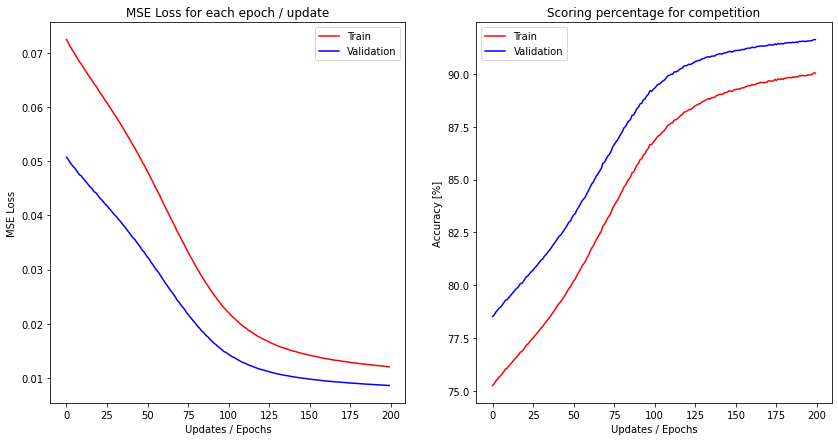

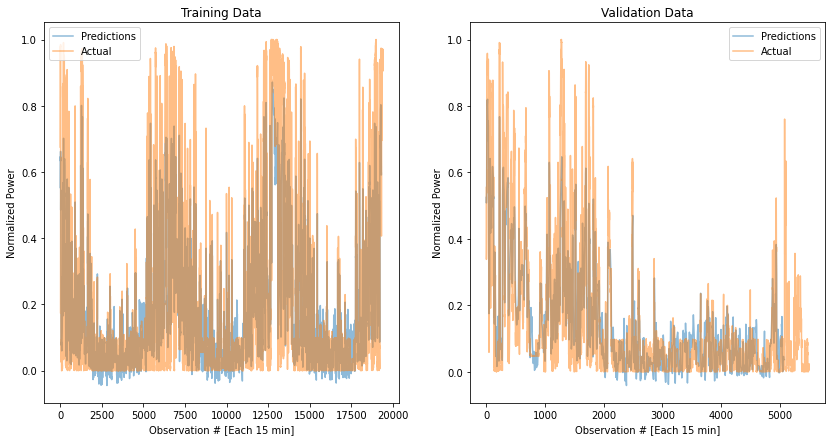

In [31]:
# net.to("cpu")
import matplotlib.pyplot as plt
print('Scoring is: ',max(valid_acc_comp_total))
print('With a mulitiplier: ', muliplier*10)
if 1:
  fig = plt.figure(figsize=(14,7))
  ax = fig.add_subplot(1,2,1)
  epoch = np.arange(len(train_acc))
  #plt.figure()
  plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
  plt.legend(['Train','Validation'])
  plt.xlabel('Updates / Epochs'), plt.ylabel('MSE Loss')
  plt.title("MSE Loss for each epoch / update")

  ax = fig.add_subplot(1,2,2)
  plt.plot(epoch, train_acc_comp_total, 'r', epoch, valid_acc_comp_total, 'b')
  plt.legend(['Train','Validation'])
  plt.xlabel('Updates / Epochs'), plt.ylabel('Accuracy [%]')
  plt.title("Scoring percentage for competition")
  plt.show()

fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(1,2,1)
ax.title.set_text("Training Data")
ax.plot(train_preds, alpha=0.5) # to.("cpu").detach() #.to("cpu")
ax.plot(y_train, alpha=0.5)
ax.set_ylabel("Normalized Power")
ax.set_xlabel("Observation # [Each 15 min]")
#ax.set_xlim([0, 3000])
ax.legend(['Predictions', "Actual"])

ax = fig.add_subplot(1,2,2)
ax.title.set_text("Validation Data")
ax.plot(valid_preds, alpha=0.5)
ax.plot(y_valid, alpha=0.5)
ax.set_ylabel("Normalized Power")
ax.set_xlabel("Observation # [Each 15 min]")
#ax.set_xlim([0, 3000])
ax.legend(['Predictions', "Actual"])

plt.show()

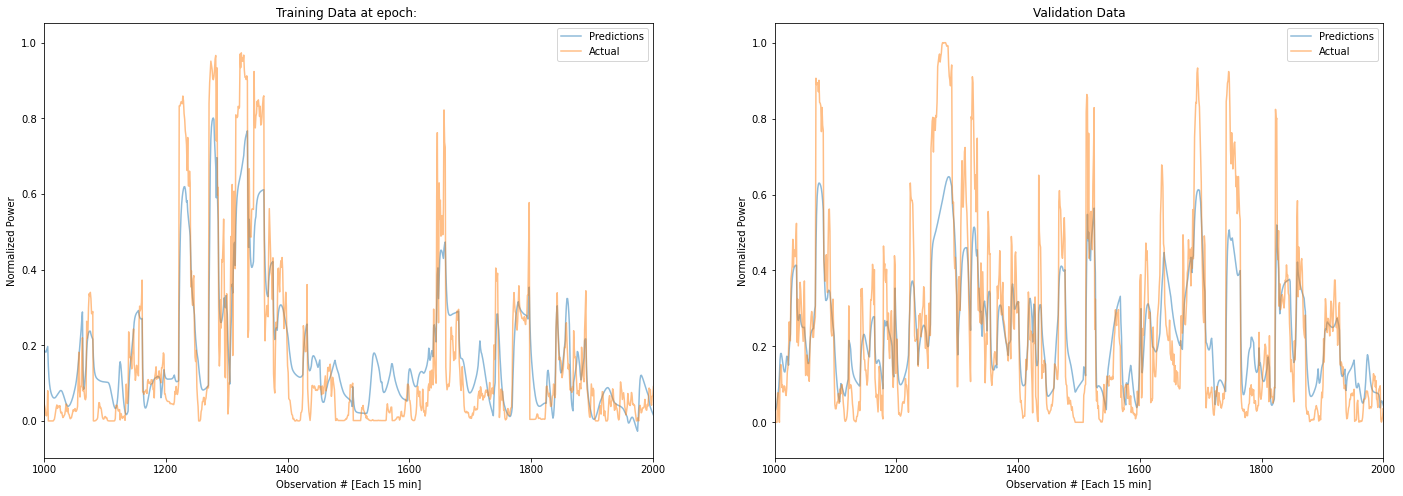

In [32]:
firstlim , limlim = 1000, 2000
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(1,2,1)
ax.title.set_text("Training Data at epoch: ")
ax.plot(train_preds*10, alpha=0.5) # to.("cpu").detach() #.to("cpu")
ax.plot(y_train, alpha=0.5)
ax.set_ylabel("Normalized Power")
ax.set_xlabel("Observation # [Each 15 min]")
ax.set_xlim([firstlim, limlim])
ax.legend(['Predictions', "Actual"])

ax = fig.add_subplot(1,2,2)
ax.title.set_text("Validation Data")
ax.plot(valid_preds, alpha=0.5)
ax.plot(y_valid, alpha=0.5)
ax.set_ylabel("Normalized Power")
ax.set_xlabel("Observation # [Each 15 min]")
ax.set_xlim([firstlim, limlim])
ax.legend(['Predictions', "Actual"])

plt.show()

In [33]:
# SAVE FIGURES
#Saving the plot as an image
SAVE = 0
if SAVE:
  savepath = "/plots/batch"+str(batch_size)+"_hid"+str(hidden)+"_lay"+str(layers)+"_ADAM_drop025"
  fig.savefig(path+savepath+'.jpg', bbox_inches='tight', dpi=150)